# OxCOVID19 (https://covid19.eng.ox.ac.uk/) - Epidemiological, Govermental Actions and Mobility data


This notebook demonstrates how to join Epidemiological, Govermental Actions and Mobility data. 

Examples for United Kingdom, Italy, Spain, United States and Poland.

In [1]:
import psycopg2
import pandas as pd
from pandas.plotting import register_matplotlib_converters 

# Connect to covid19db.org
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)
cur = conn.cursor()
cur.execute("""SELECT 
                  e.*,
                  g.actions, 
                  m.transit_stations, m.residential, m.workplace,
                  m.parks, m.retail_recreation, m.grocery_pharmacy
               FROM 
                   government_response AS g 
               LEFT JOIN 
                   mobility AS m
               ON 
                   g.date = m.date AND 
                   g.countrycode = m.countrycode AND 
                   COALESCE(g.adm_area_1, '') = COALESCE(m.adm_area_1, '') AND
                   COALESCE(g.adm_area_2, '') = COALESCE(m.adm_area_2, '') AND
                   COALESCE(g.adm_area_3, '') = COALESCE(m.adm_area_3, '')
               LEFT JOIN
                   epidemiology AS e
               ON
                   g.date = e.date AND 
                   g.countrycode = e.countrycode AND 
                   COALESCE(g.adm_area_1, '') = COALESCE(e.adm_area_1, '') AND
                   COALESCE(g.adm_area_2, '') = COALESCE(e.adm_area_2, '') AND
                   COALESCE(g.adm_area_3, '') = COALESCE(e.adm_area_3, '')
               WHERE 
                   m.source = 'GOOGLE_MOBILITY' AND
                   e.date < NOW() AND 
                   e.date > '2020-02-01' AND 
                   e.source = 'WRD_ECDC' AND
                   e.countrycode IN ('ITA', 'ESP', 'GBR', 'POL', 'USA')
               ORDER BY 
                   e.date
            """)
    
govtrack_mobility_data = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
conn.close()

In [2]:
govtrack_mobility_data.dropna(subset=['confirmed'], inplace=True)
govtrack_mobility_data.head()

,source,date,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,...,hospitalised_icu,quarantined,gid,actions,transit_stations,residential,workplace,parks,retail_recreation,grocery_pharmacy
0,WRD_ECDC,2020-02-15,Italy,ITA,None,None,None,None,3,None,...,None,None,[ITA],"{'policyActions': [{'notes': '', 'flagged': No...",9.0,-1.0,0.0,35.0,3.0,-1.0
1,WRD_ECDC,2020-02-15,United States,USA,None,None,None,None,15,None,...,None,None,[USA],"{'policyActions': [{'notes': None, 'flagged': ...",3.0,-1.0,2.0,15.0,6.0,-1.0
2,WRD_ECDC,2020-02-15,Spain,ESP,None,None,None,None,2,None,...,None,None,[ESP],"{'policyActions': [{'notes': '', 'flagged': No...",8.0,-2.0,0.0,26.0,2.0,-2.0
3,WRD_ECDC,2020-02-15,United Kingdom,GBR,None,None,None,None,9,None,...,None,None,[GBR],"{'policyActions': [{'notes': '', 'flagged': No...",-12.0,2.0,-4.0,-35.0,-12.0,2.0
4,WRD_ECDC,2020-02-16,Spain,ESP,None,None,None,None,2,None,...,None,None,[ESP],"{'policyActions': [{'notes': '', 'flagged': No...",5.0,-2.0,-1.0,13.0,2.0,-2.0


### Policy extraction

In [11]:
# Extract actions and store first occurence of policy_type_code in dict
import numpy as np
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, 14) )
marker_types = ('o', '.', ',', 'x', '+', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

def check_policy_actions(row, policy_actions):
    date, confirmed, actions = row  
    
    policy = actions.get('policyActions', {})
    for action in policy:
        policy_code = action.get('policy_type_code')
        policyvalue = action.get('policyvalue_actual', 0)
        
        if policy_code in ['S99', 'S12']: # Skip 'Testing Framework' and 'No data' actions
            continue
        
        policy_code_int = int(policy_code.replace('S','').replace('C','').replace('E','').replace('H','').replace('M','').replace('NON','0'))
        policy_color = colors[policy_code_int]          
            
        if isinstance(policyvalue, int) and policyvalue > 0: 
            if policy_code not in policy_actions:
                policy_actions[policy_code] = {
                        'first_date': date,
                        'confirmed': confirmed,
                        'policy_type_display': f"{policy_code} - {date}, {action.get('policy_type_display')}",
                        'policy_type_code': policy_code,
                        'color': policy_color,
                        'marker': marker_types[policy_code_int % 19]
                }        
        
    return policy_actions

### Plotting functions

In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib.dates as mdates

def plot(govtrack_data, policy_actions):
    legend_left_padding = 1.2
    
    categories = ['transit_stations','residential','workplace','parks','retail_recreation','grocery_pharmacy']
    for category in categories:
        category_pretty = category.replace('_', ' ').capitalize()
        
        fig, ax1 = plt.subplots()
        
        # Confirmed, Dead, Recovered
        ax1.plot(govtrack_data['confirmed'],  linestyle='-', color='blue', label='Confirmed cases')
        ax1.plot(govtrack_data['dead'],  linestyle='--', color='red', label='Dead')
        ax1.plot(govtrack_data['recovered'],  linestyle='-.', color='brown', label='Recovered')
        
        ax1.tick_params(axis='y', labelcolor='black')
        
        # Govermental actions
        sorted_lebels = sorted(policy_actions.items(), key=lambda key: key[1].get('first_date'))
        for key, value in sorted_lebels:   
            date = value.get('first_date')
            y_value = value.get('confirmed')
            label = value.get('policy_type_display')
            ax1.scatter(date, y_value, 
                       color=value.get('color'), 
                       marker=value.get('marker'),
                       alpha=0.8, 
                       s=100, 
                       label=label, 
                       cmap=cm.jet)

        ax1.set_ylabel('Number of cases', color='black')
        ax1.set_title(category_pretty)
        ax1.xaxis.set_major_locator(mdates.MonthLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));
        ax1.legend(loc='center left', bbox_to_anchor=(legend_left_padding, 0.35), labelspacing=1)
        
        # Mobility
        categort_color = 'green'
        ax3 = ax1.twinx() 
        ax3.plot(govtrack_data[category],  linestyle='-', color=categort_color, label=category_pretty)
        ax3.set_ylabel(category_pretty + ' [%]', color=categort_color)
        ax3.tick_params(axis='y', labelcolor=categort_color)
        ax3.grid(False)
        ax3.legend(loc='center left', bbox_to_anchor=(legend_left_padding, 1.06), labelspacing=1)
        
        fig.autofmt_xdate()

In [13]:
def plot_country(data, country_code):
    govtrack = data[data['countrycode'] == country_code].reset_index()
    policy_actions = {}
    _ = govtrack[['date','confirmed','actions']].apply(lambda row: check_policy_actions(row, policy_actions), axis=1)
    plot(govtrack.set_index('date'), policy_actions)

### Govermental actions and people mobility for Italy

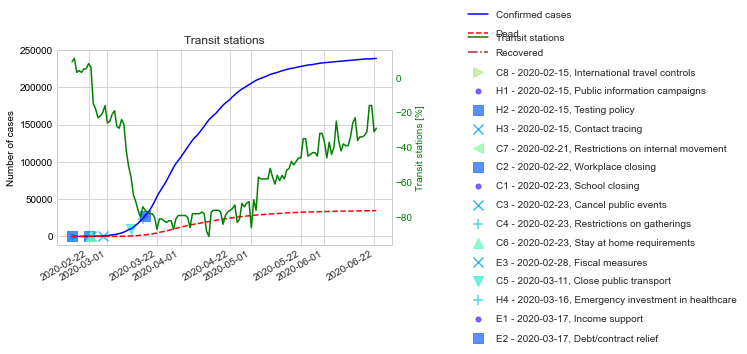

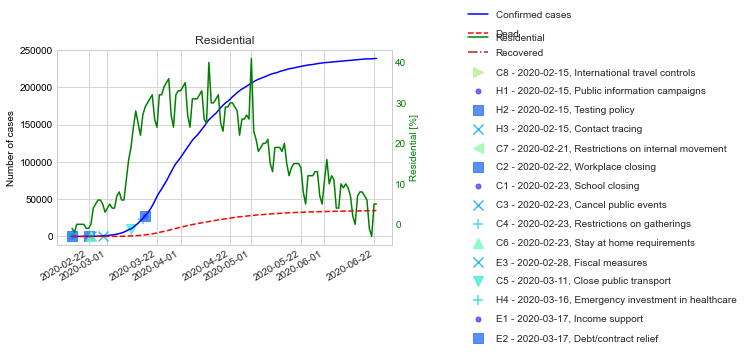

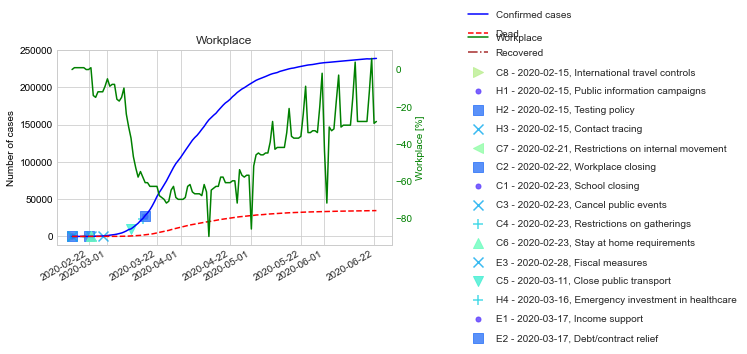

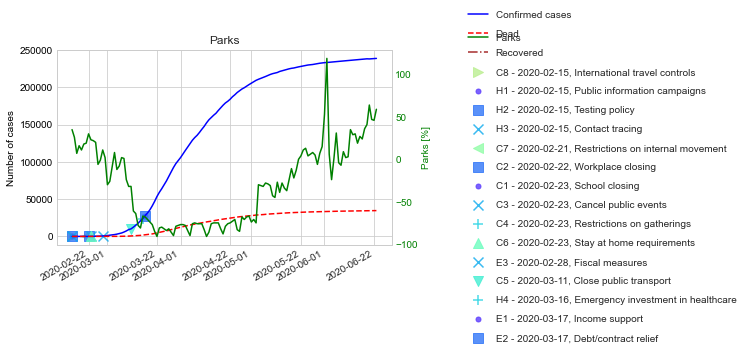

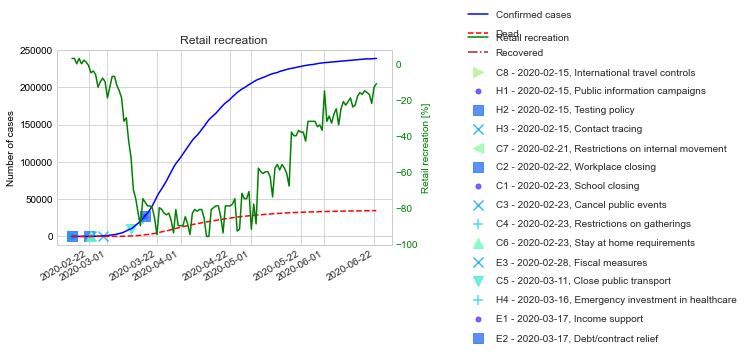

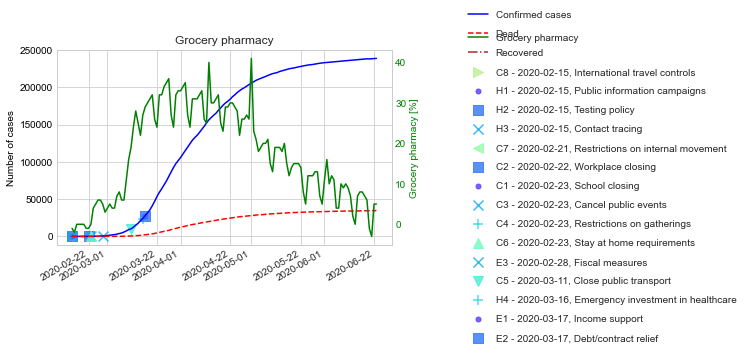

In [14]:
plot_country(govtrack_mobility_data, 'ITA')

### Govermental actions and people mobility for Spain

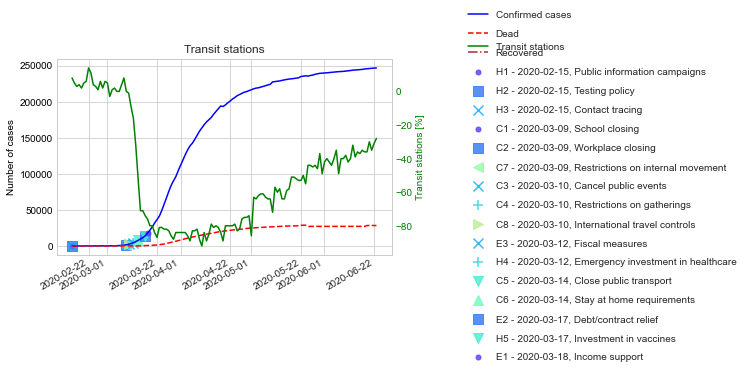

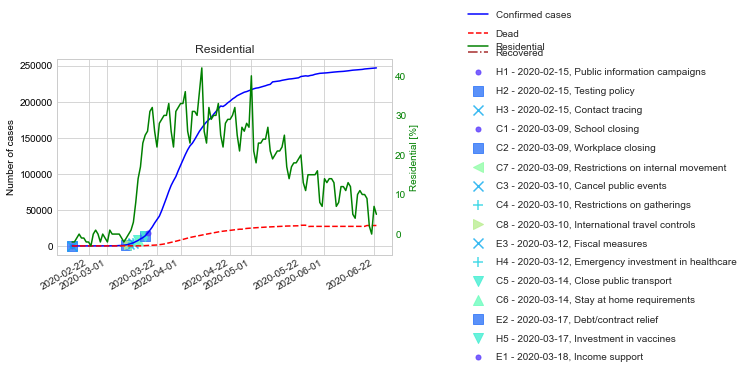

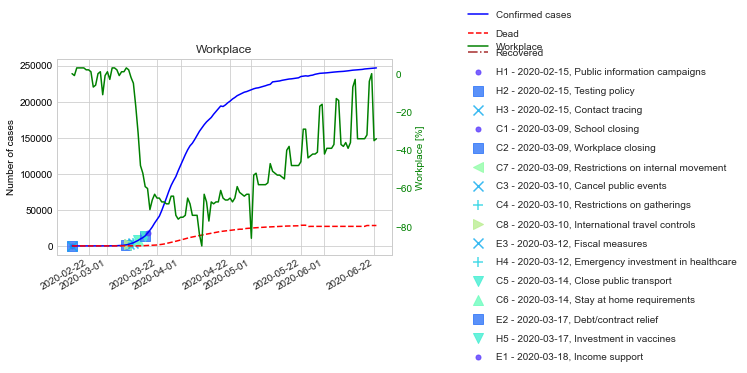

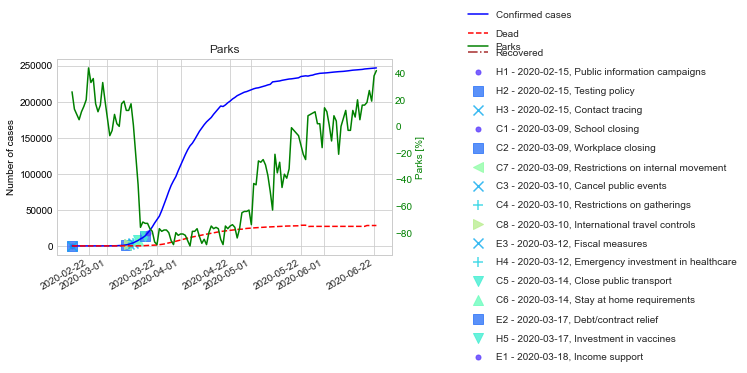

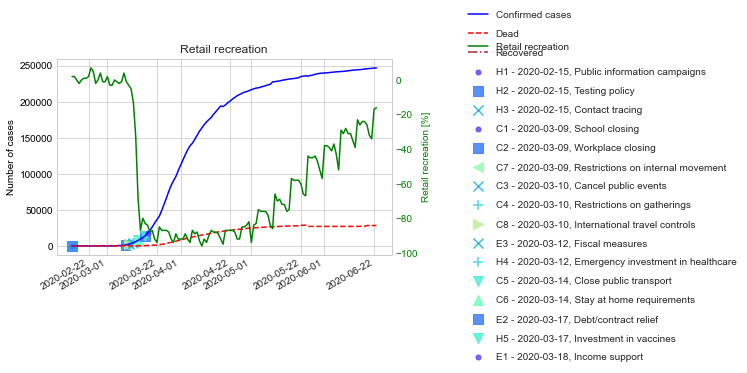

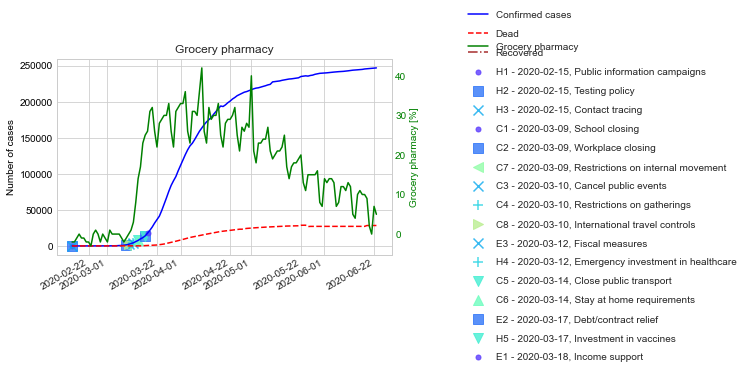

In [15]:
plot_country(govtrack_mobility_data, 'ESP')

### Govermental actions and people mobility for Great Britan

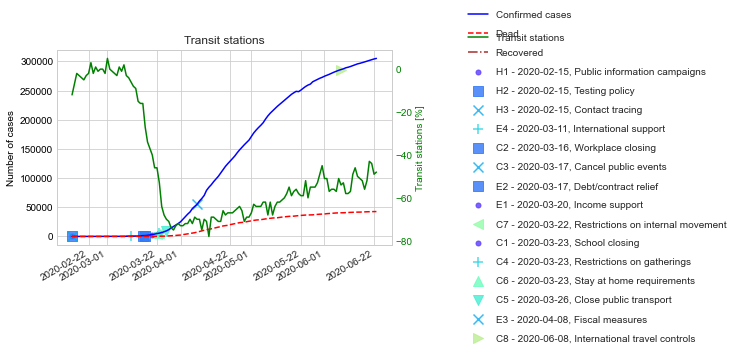

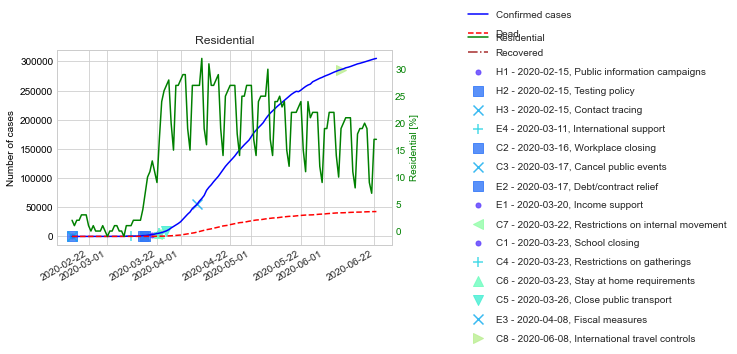

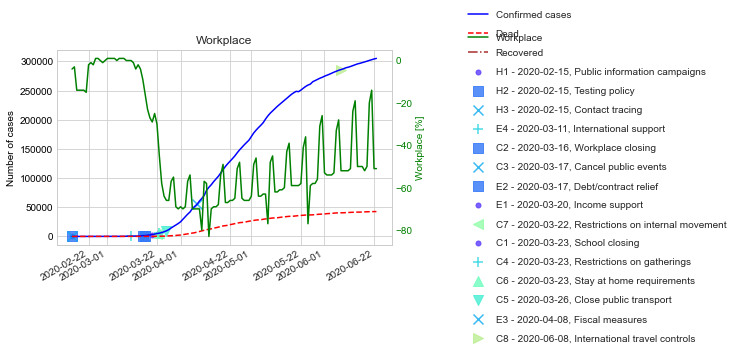

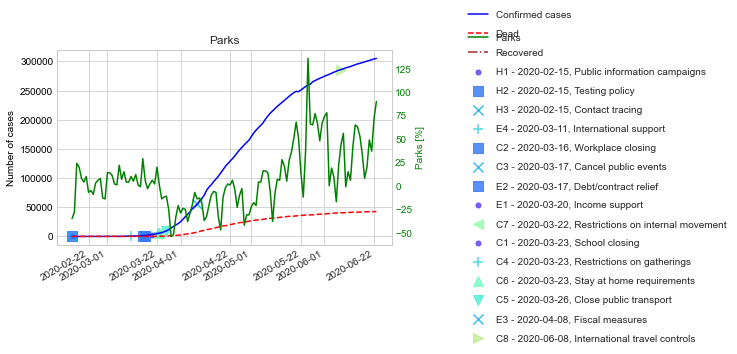

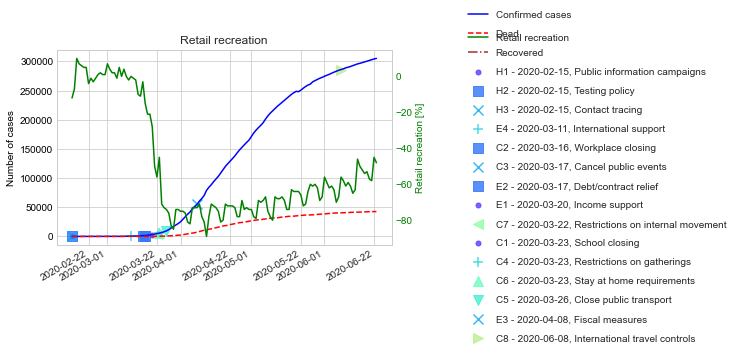

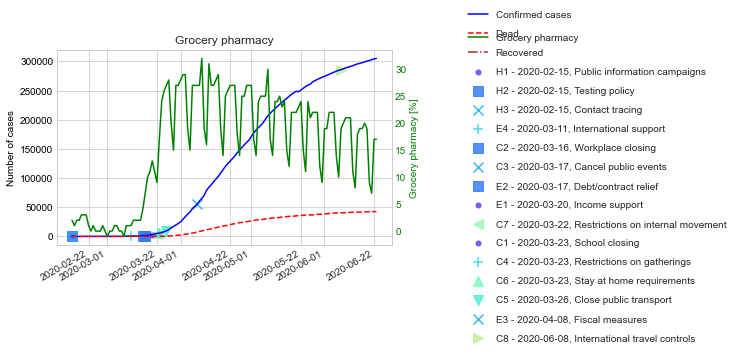

In [16]:
plot_country(govtrack_mobility_data, 'GBR')

### Govermental actions and people mobility for Poland

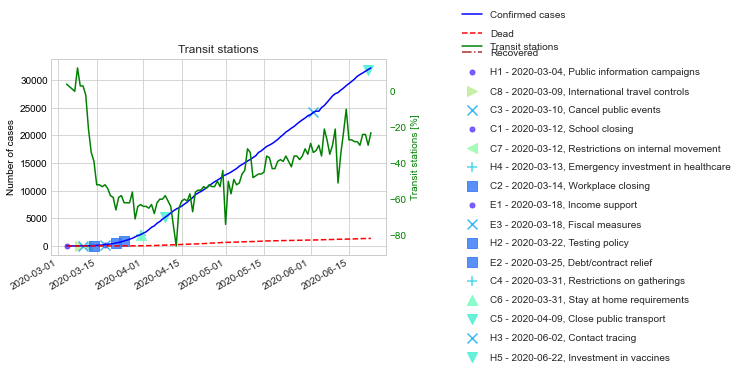

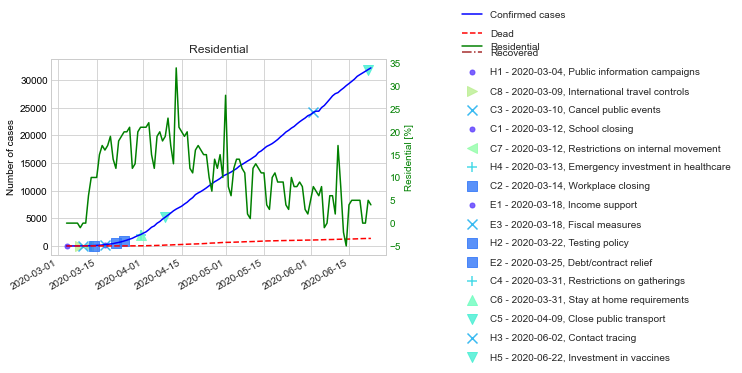

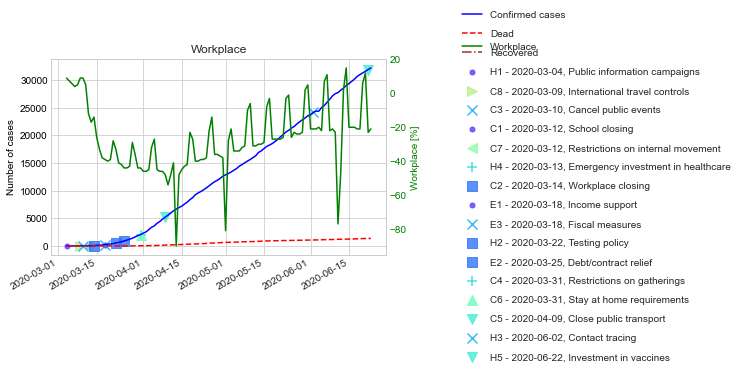

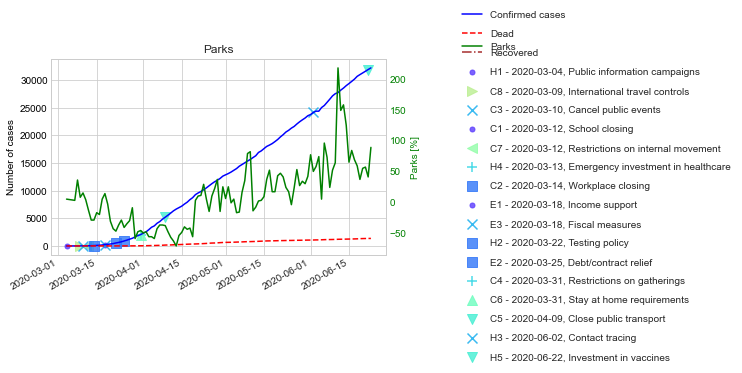

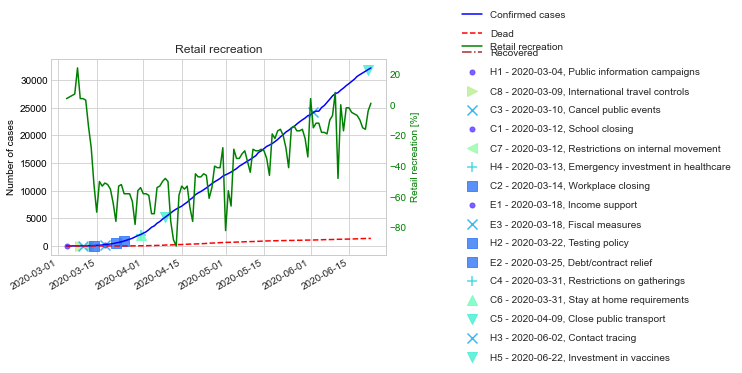

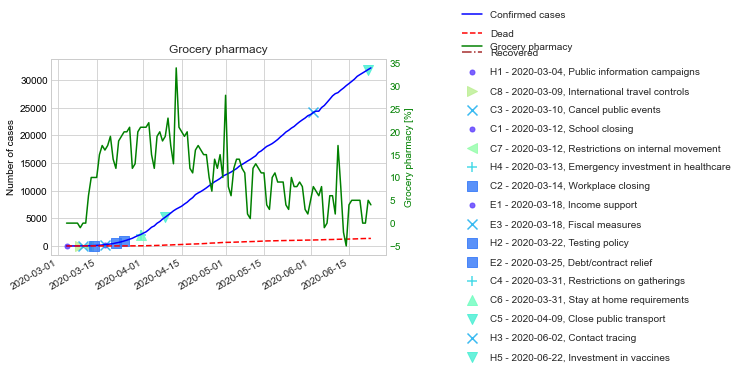

In [17]:
plot_country(govtrack_mobility_data, 'POL')

### Govermental actions and people mobility for United States

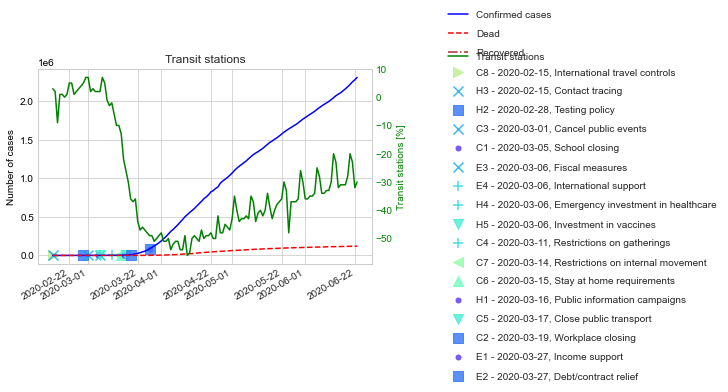

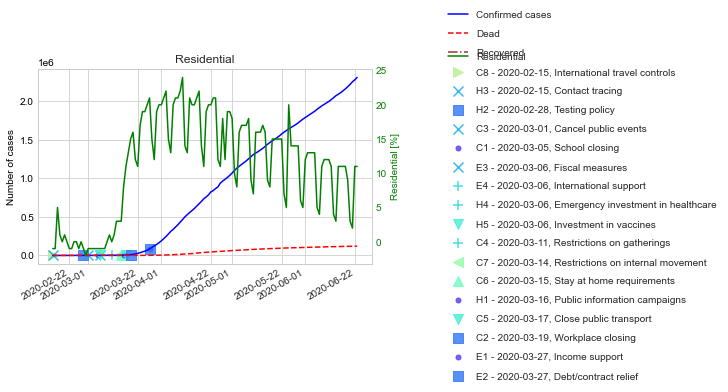

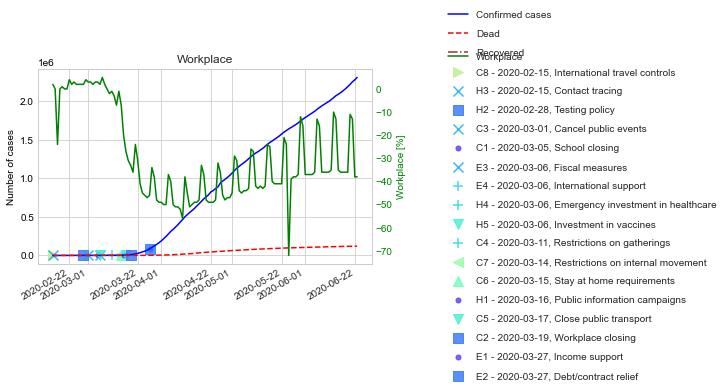

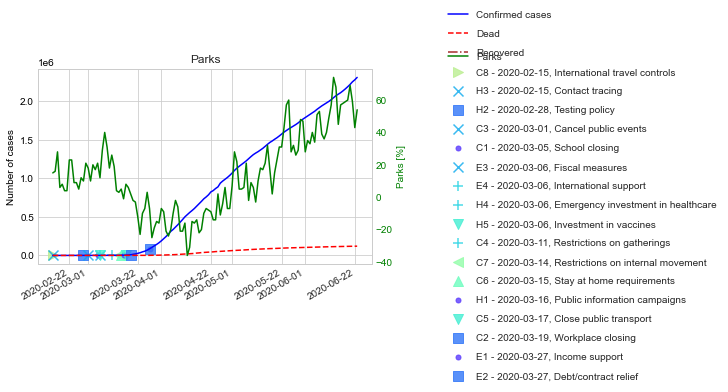

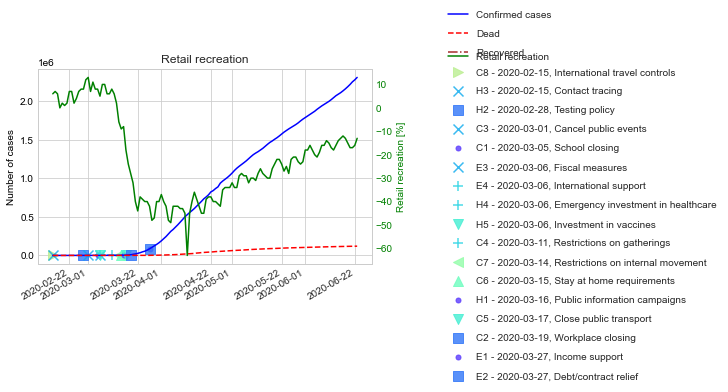

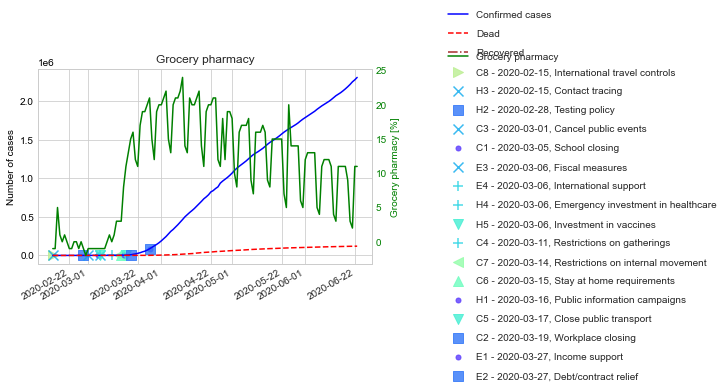

In [18]:
plot_country(govtrack_mobility_data, 'USA')